# Exercise Sheet 11 - MLP
Yiping Deng, Shalom-David Anifowoshe

In [142]:
# initialize numpy enviroment
import numpy as np
from numpy import square
import matplotlib.pyplot as plt

In [143]:
# Code for visualizing MLP structure

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

## Structure of the Multiple Layer Perceptron
We use the classic structure of Multiple Layer Perceptron, with

1. Input Layer: 2 input neurons and 1 bias unit
2. One Hidden Layer: 2 hidden neurons with 1 bias Unit
3. Output Layer: 1 output neurons

### Bias unit
Bias unit guarantees that it is a affine combination of previous layer inside of the neuron, increasing the model flexibility of each neurons.


The following is the visualization of the MLP ( note that bias unit is emitted)

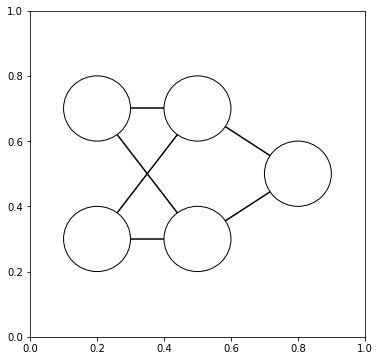

In [144]:
mlp_fig = plt.figure(figsize=(6, 6))
draw_neural_net(mlp_fig.gca(), .2, .8, .1, .9, [2, 2, 1])

## Implementation of the MLP
Firstly, let's define the necessary activation function $\sigma$ and the quadratic loss function

In [145]:
def sigmoid(x):
    """Sigmoid Function
    Input: A vector in any dimension
    Output: Applying Sigmoid function elementwise
    """
    exp_part = np.exp(-x)
    return 1 / (1 + exp_part)

def sigmoid_grad(x):
    """Gradient of the sigmoid function
    Input: A vector in any dimension
    Output: Calculate Gradient of Sigmoid function elementwise
    """
    sig = sigmoid(x)
    return np.multiply(sig, 1 - sig)

def loss(y_pred, y):
    diff = y_pred - y
    np.sum(np.square(diff))
    

    
def mean_square_error(y_pred, y):
    m, n = y_pred.shape
    l = loss(y_pred, y)
    return l / m / n

The Gradient of the Sigmoid function is calculated using the following formula:
$$ \sigma'(x) = \sigma(x) \cdot (1 - \sigma(x)) $$

Given two weight matrix $W_1, W_2$, representing the weight from the input layer to the hidden layer and from the hiddden layer to the output layer, including the bias term, we can conclude that $W_1 \in \mathbb{R}^{2 \times 3}$ and $W_2 \in \mathbb{R}^{1 \times 3}$.

## Forward Propagation
Our Entire Neural Network can be represent as a single function:
$$ N: \mathbb{R}^2 \to \mathbb{R} $$
Such function will:
1. Assiciate the input $X \in \mathbb{R}^2$ with a bias term, forming $X_{biased}$
2. Calculate the offine combination
$$ z_2 = W_1 \cdot X_{biased} $$, where $z_2 \in \mathbb{R}^2$
3. Apply the Sigmoid function, obtaining the value of the neurons
$$ a_2 = \sigma(z_2) $$, where $a_2 \in \mathbb{R}^2$
4. Assiciate $a_2$ with a bias term
5. Calculate the affine combination and return
$$ z_3 = W_2 \cdot a_2 $$, where $z_3 \in \mathbb{R}$
6. Calculate $a_3 = \sigma(z_3)$. Note that in the lecture note, we do not apply sigmoid function for the last layer.
However, we applied sigmoid here because we want the result to be in the inteval $[0,1]$ instead of $\mathbb{R}$

In [146]:
def neural_net(X, W1, W2):
    """Implementation of the MLP
    Input: takes input data X in 2 dimension, 2 weight matrix
    """
    # bias term
    X_b = np.ones((3,1))
    X_b[1:] = X
    a_1 = X_b
    
    # calculate z_2
    z_2 = np.matmul(W1, a_1)
    
    # calculate a_2
    a_2 = sigmoid(z_2)
    
    # associate with bias
    b_2 = np.ones((3, 1))
    b_2[1:] = a_2
    a_2 = b_2
    
    # calculate z_3
    z_3 = np.matmul(W2, a_2)
    
    # calculate a_3
    a_3 = sigmoid(z_3)
    
    return a_3[0][0]

## Calculate the gradient with respect to $W_1$ and $W_2$ using Backpropagation

We are using backpropagation to train $W^{(1)}$ and $W^{(2)}$

First, perform a full forward propagation of the neural network to obtain
$a_1, a_2, a_3, z_2, z_3$

Second, calculate
$$ \delta^{(3)} = a_k^{(3)} - y_k $$
$$ \delta^{(2)} = W_2' \delta^{(3)}.*\sigma'(z^{(2)}) $$

Finally, calculate the gradient at layer $l$ using
\begin{equation}
\frac{\partial}{\partial W_{ij}^{(l)}} = \delta^{(l + 1)} \cdot (a^{(l)})'
\end{equation}

In [148]:
def neural_net_train(X, W1, W2, Y):
    """Implementation of the MLP
    Input: takes input data X in 2 dimension, 2 weight matrix, y
    Output: 
    """
    # bias term
    X_b = np.ones((3,1))
    X_b[1:] = X
    a_1 = X_b
    
    # calculate z_2
    z_2 = np.matmul(W1, a_1)
    
    # calculate a_2
    a_2 = sigmoid(z_2)
    
    # associate with bias
    b_2 = np.ones((3, 1))
    b_2[1:] = a_2
    a_2 = b_2
    
    # calculate z_3
    z_3 = np.matmul(W2, a_2)
    
    a_3 = sigmoid(z_3)
    # forward propagation end
    # -----------------------
    
    # start of backpropagation
    
    # delta 3 in  1 x 1
    delta_3 = a_3 - Y 
    
    # delta 2 in 2 x 1
    delta_2 = np.multiply(np.matmul(W2.T, delta_3)[1:], sigmoid_grad(z_2))
    
    # we don't have delta 1
    grad_w_1 = np.matmul(delta_2, a_1.T)
    
    grad_w_2 = np.matmul(delta_3, a_2.T)
    # grad_w_2 = np.matmul(delta_3.T, a_2)
    
    return a_3, grad_w_1, grad_w_2# grad_w_2

## Dealing with Multiple training data at the same time
The gradient formula is averaged. Namely
$$\frac{\partial}{\partial W_{ij}^{(l)}} = \frac{1}{m} \sum_{i = 1}^{m} \delta_{(i)}^{(l + 1)} \cdot (a_{(i)}^{(l)})' $$

In [163]:
# accumulate the gradient result
def batch_neural_net_train(X, W1, W2, Y):
    # X contains m training examples as row vectors
    # X is   m x 3
    m, _ = X.shape
    
    grad_w_1_acc = np.zeros((2,3))
    grad_w_2_acc = np.zeros((1,3))
    pred_all = np.zeros((m, 1))
    for i in range(m):
        pred, grad_w_1, grad_w_2 = neural_net_train(np.asmatrix(X[i]).T, W1, W2, np.asmatrix(Y[i]))
        grad_w_1_acc = grad_w_1_acc - grad_w_1
        grad_w_2_acc = grad_w_2_acc - grad_w_2
        pred_all[i] = pred[0][0]
    error = np.sum(np.square(pred_all - Y)) / m
    return pred_all, grad_w_1_acc / m, grad_w_2_acc / m, error

## Gradient Decent
We optimize our weight using gradient decent.
We update the weight using the following formula:
$$ W_{ij}^{(l)} = W_{ij}^{(l)} - \alpha * \frac{\partial}{\partial W_{ij}^{(l)}} $$

In [194]:
def train(X, Y, step = 2000, alpha = 4.0):
    # initiate w_1, w_2
    w_1 = np.random.random((2,3))
    w_2 = np.random.random((1, 3))
    
    # train
    for i in range(step):
        pred, grad_w_1, grad_w_2, err = batch_neural_net_train(X, w_1, w_2, Y)
        w_1_new = w_1 + alpha * grad_w_1
        w_2_new = w_2 + alpha * grad_w_2
        w_1 = w_1_new
        w_2 = w_2_new
        print('step: {} - error: {}'.format(i, err))
    return w_1, w_2

We explicitly print the training error, and after the experiment, we find the optimal $\alpha = 4.0$ and $step = 2000$

In [195]:
# build up a training data
X = np.asmatrix([[1,1], [1,0], [0,1], [0, 0]])
Y = np.asmatrix([[0], [1], [1], [0]])

# train the neural network
w_1, w_2 = train(X, Y)

step: 0 - error: 0.2939193497756383
step: 1 - error: 0.29319507426126695
step: 2 - error: 0.289667900724157
step: 3 - error: 0.28582603670208573
step: 4 - error: 0.28037458277224714
step: 5 - error: 0.2760029605549789
step: 6 - error: 0.270876412878756
step: 7 - error: 0.26725554066364116
step: 8 - error: 0.26327512259619307
step: 9 - error: 0.2606564036362285
step: 10 - error: 0.25778999908351824
step: 11 - error: 0.25599346623721136
step: 12 - error: 0.2539397001552632
step: 13 - error: 0.2527033839998027
step: 14 - error: 0.251166140326149
step: 15 - error: 0.25027221766250557
step: 16 - error: 0.24903148742363035
step: 17 - error: 0.2483266113362061
step: 18 - error: 0.2472329388621703
step: 19 - error: 0.24661562477663518
step: 20 - error: 0.24556866308478242
step: 21 - error: 0.2449727026802069
step: 22 - error: 0.24390257866498855
step: 23 - error: 0.24328434668642085
step: 24 - error: 0.2421388007093338
step: 25 - error: 0.24146909194523017
step: 26 - error: 0.24020526226939964

step: 382 - error: 7.334715032719965e-05
step: 383 - error: 7.284049111434045e-05
step: 384 - error: 7.233899768434925e-05
step: 385 - error: 7.184260062811961e-05
step: 386 - error: 7.135123169140613e-05
step: 387 - error: 7.086482375195268e-05
step: 388 - error: 7.038331079714179e-05
step: 389 - error: 6.99066279021554e-05
step: 390 - error: 6.943471120863444e-05
step: 391 - error: 6.89674979038247e-05
step: 392 - error: 6.85049262001903e-05
step: 393 - error: 6.804693531549444e-05
step: 394 - error: 6.759346545332248e-05
step: 395 - error: 6.714445778404692e-05
step: 396 - error: 6.669985442621413e-05
step: 397 - error: 6.625959842834953e-05
step: 398 - error: 6.58236337511666e-05
step: 399 - error: 6.539190525016767e-05
step: 400 - error: 6.496435865863363e-05
step: 401 - error: 6.45409405709834e-05
step: 402 - error: 6.412159842650464e-05
step: 403 - error: 6.370628049343458e-05
step: 404 - error: 6.329493585339542e-05
step: 405 - error: 6.288751438615785e-05
step: 406 - error: 6.

step: 600 - error: 2.354813139985956e-05
step: 601 - error: 2.345404441294828e-05
step: 602 - error: 2.3360515091951402e-05
step: 603 - error: 2.3267539064367833e-05
step: 604 - error: 2.317511200028423e-05
step: 605 - error: 2.308322961188073e-05
step: 606 - error: 2.299188765294142e-05
step: 607 - error: 2.2901081918371795e-05
step: 608 - error: 2.281080824372438e-05
step: 609 - error: 2.272106250473161e-05
step: 610 - error: 2.2631840616839047e-05
step: 611 - error: 2.254313853475007e-05
step: 612 - error: 2.2454952251977167e-05
step: 613 - error: 2.236727780039688e-05
step: 614 - error: 2.2280111249810796e-05
step: 615 - error: 2.219344870751236e-05
step: 616 - error: 2.2107286317860256e-05
step: 617 - error: 2.2021620261857885e-05
step: 618 - error: 2.1936446756737193e-05
step: 619 - error: 2.185176205554704e-05
step: 620 - error: 2.176756244674961e-05
step: 621 - error: 2.1683844253821908e-05
step: 622 - error: 2.1600603834859904e-05
step: 623 - error: 2.15178375821866e-05
step: 

step: 1003 - error: 7.1565876369505605e-06
step: 1004 - error: 7.140584137954152e-06
step: 1005 - error: 7.124633912689701e-06
step: 1006 - error: 7.1087367259472805e-06
step: 1007 - error: 7.09289234381035e-06
step: 1008 - error: 7.077100533645643e-06
step: 1009 - error: 7.061361064096553e-06
step: 1010 - error: 7.045673705073437e-06
step: 1011 - error: 7.030038227746218e-06
step: 1012 - error: 7.014454404535676e-06
step: 1013 - error: 6.998922009105115e-06
step: 1014 - error: 6.983440816352917e-06
step: 1015 - error: 6.968010602403459e-06
step: 1016 - error: 6.952631144600088e-06
step: 1017 - error: 6.937302221496812e-06
step: 1018 - error: 6.92202361285064e-06
step: 1019 - error: 6.906795099612536e-06
step: 1020 - error: 6.89161646392237e-06
step: 1021 - error: 6.876487489098074e-06
step: 1022 - error: 6.861407959629765e-06
step: 1023 - error: 6.846377661172811e-06
step: 1024 - error: 6.8313963805382195e-06
step: 1025 - error: 6.816463905686303e-06
step: 1026 - error: 6.801580025721

step: 1212 - error: 4.695571953445719e-06
step: 1213 - error: 4.687031034834224e-06
step: 1214 - error: 4.6785132640928585e-06
step: 1215 - error: 4.670018557957006e-06
step: 1216 - error: 4.661546833536079e-06
step: 1217 - error: 4.653098008310129e-06
step: 1218 - error: 4.644672000128207e-06
step: 1219 - error: 4.6362687272064555e-06
step: 1220 - error: 4.6278881081264525e-06
step: 1221 - error: 4.619530061832252e-06
step: 1222 - error: 4.611194507630466e-06
step: 1223 - error: 4.6028813651852525e-06
step: 1224 - error: 4.59459055451958e-06
step: 1225 - error: 4.586321996011586e-06
step: 1226 - error: 4.578075610392526e-06
step: 1227 - error: 4.569851318745617e-06
step: 1228 - error: 4.561649042504809e-06
step: 1229 - error: 4.553468703450279e-06
step: 1230 - error: 4.545310223710003e-06
step: 1231 - error: 4.537173525755449e-06
step: 1232 - error: 4.5290585324008985e-06
step: 1233 - error: 4.520965166800993e-06
step: 1234 - error: 4.512893352449707e-06
step: 1235 - error: 4.50484301

step: 1549 - error: 2.7461771982471267e-06
step: 1550 - error: 2.7423394466199884e-06
step: 1551 - error: 2.7385096942107604e-06
step: 1552 - error: 2.734687918875144e-06
step: 1553 - error: 2.730874098543983e-06
step: 1554 - error: 2.7270682112249865e-06
step: 1555 - error: 2.7232702350016894e-06
step: 1556 - error: 2.7194801480328043e-06
step: 1557 - error: 2.715697928552251e-06
step: 1558 - error: 2.711923554868677e-06
step: 1559 - error: 2.708157005365707e-06
step: 1560 - error: 2.7043982585006966e-06
step: 1561 - error: 2.700647292805265e-06
step: 1562 - error: 2.696904086884317e-06
step: 1563 - error: 2.6931686194165137e-06
step: 1564 - error: 2.6894408691531808e-06
step: 1565 - error: 2.6857208149183102e-06
step: 1566 - error: 2.6820084356086204e-06
step: 1567 - error: 2.678303710192897e-06
step: 1568 - error: 2.6746066177114767e-06
step: 1569 - error: 2.670917137276596e-06
step: 1570 - error: 2.667235248071279e-06
step: 1571 - error: 2.6635609293500248e-06
step: 1572 - error: 2

step: 1777 - error: 2.0420666294673956e-06
step: 1778 - error: 2.0396001629157365e-06
step: 1779 - error: 2.0371381417473784e-06
step: 1780 - error: 2.0346805553174163e-06
step: 1781 - error: 2.0322273930123865e-06
step: 1782 - error: 2.029778644250619e-06
step: 1783 - error: 2.027334298482324e-06
step: 1784 - error: 2.024894345188453e-06
step: 1785 - error: 2.022458773881726e-06
step: 1786 - error: 2.0200275741063094e-06
step: 1787 - error: 2.0176007354370417e-06
step: 1788 - error: 2.015178247479808e-06
step: 1789 - error: 2.012760099871595e-06
step: 1790 - error: 2.010346282279903e-06
step: 1791 - error: 2.0079367844033413e-06
step: 1792 - error: 2.0055315959707794e-06
step: 1793 - error: 2.003130706741047e-06
step: 1794 - error: 2.0007341065041354e-06
step: 1795 - error: 1.9983417850796747e-06
step: 1796 - error: 1.9959537323180095e-06
step: 1797 - error: 1.9935699380988478e-06
step: 1798 - error: 1.9911903923325066e-06
step: 1799 - error: 1.9888150849582064e-06
step: 1800 - error:

step: 1973 - error: 1.632100741785554e-06
step: 1974 - error: 1.630335580564421e-06
step: 1975 - error: 1.6285732690038492e-06
step: 1976 - error: 1.6268138009901564e-06
step: 1977 - error: 1.6250571704260677e-06
step: 1978 - error: 1.6233033712302935e-06
step: 1979 - error: 1.621552397338046e-06
step: 1980 - error: 1.6198042427004328e-06
step: 1981 - error: 1.6180589012849725e-06
step: 1982 - error: 1.616316367075309e-06
step: 1983 - error: 1.6145766340709626e-06
step: 1984 - error: 1.61283969628768e-06
step: 1985 - error: 1.6111055477566834e-06
step: 1986 - error: 1.609374182525641e-06
step: 1987 - error: 1.6076455946576771e-06
step: 1988 - error: 1.6059197782318966e-06
step: 1989 - error: 1.6041967273431448e-06
step: 1990 - error: 1.6024764361017286e-06
step: 1991 - error: 1.6007588986339827e-06
step: 1992 - error: 1.599044109081545e-06
step: 1993 - error: 1.5973320616014528e-06
step: 1994 - error: 1.5956227503666286e-06
step: 1995 - error: 1.5939161695653684e-06
step: 1996 - error:

The prediction is just performing the forward propagation algorithms.

In [196]:
def predict(X, w_1, w_2):
    m, _ = X.shape
    pred = np.zeros((m, 1))
    for i in range(m):
        if neural_net(np.asmatrix(X[i]).T, w_1, w_2) > 0.5:
            pred[i][0] = 1
        else:
            pred[i][0] = 0
    return pred     

In [197]:
predict(X, w_1, w_2)

array([[0.],
       [1.],
       [1.],
       [0.]])